## Business Case:
As a data scientist working at Apollo, the ultimate goal is to tease out meaningful and actionable insights from Patient-level collected data. You can help Apollo hospitals to be more efficient, influence diagnostic and treatment processes, and to map the spread of a pandemic.

One of the best examples of data scientists making a meaningful difference at a global level is in the response to the COVID-19 pandemic, where they have improved information collection, provided ongoing and accurate estimates of infection spread and health system demand, and assessed the effectiveness of government policies.

The company wants to know:

Which variables are significant in predicting the reason for hospitalization for different regions;
How well some variables like viral load, smoking, and severity level describe the hospitalization charges;

In [1]:
import pandas as pd
import seaborn as sbn
import matplotlib.pyplot as plt
from statsmodels.stats.proportion import proportions_ztest # For proportion Z-test
from statsmodels.formula.api import ols # For n-way ANOVA
from statsmodels.stats.anova import anova_lm # For n-way ANOVA
from scipy.stats import chi2_contingency # For Chi-Sq
from scipy import stats

In [3]:
df=pd.read_csv('apollo_hospitals.csv',index_col=0)


In [4]:
df.head()

,age,sex,smoker,region,viral load,severity level,hospitalization charges
0,19,female,yes,southwest,9.30,0,42212
1,18,male,no,southeast,11.26,1,4314
2,28,male,no,southeast,11.00,3,11124
3,33,male,no,northwest,7.57,0,54961
4,32,male,no,northwest,9.63,0,9667


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   age                      1338 non-null   int64  
 1   sex                      1338 non-null   object 
 2   smoker                   1338 non-null   object 
 3   region                   1338 non-null   object 
 4   viral load               1338 non-null   float64
 5   severity level           1338 non-null   int64  
 6   hospitalization charges  1338 non-null   int64  
dtypes: float64(1), int64(3), object(3)
memory usage: 83.6+ KB


In [6]:
df.isnull().sum()/len(df)*100


age                        0.0
sex                        0.0
smoker                     0.0
region                     0.0
viral load                 0.0
severity level             0.0
hospitalization charges    0.0
dtype: float64

In [7]:
df.select_dtypes('object').columns

Index(['sex', 'smoker', 'region'], dtype='object')

In [8]:
df.describe(include='object').T

,count,unique,top,freq
sex,1338,2,male,676
smoker,1338,2,no,1064
region,1338,4,southeast,364


In [9]:
import numpy as np
df.describe(include=np.number).T


,count,mean,std,min,25%,50%,75%,max
age,1338.0,39.207025,14.049960,18.00,27.0000,39.00,51.0000,64.00
viral load,1338.0,10.221233,2.032796,5.32,8.7625,10.13,11.5675,17.71
severity level,1338.0,1.094918,1.205493,0.00,0.0000,1.00,2.0000,5.00
hospitalization charges,1338.0,33176.058296,30275.029296,2805.00,11851.0000,23455.00,41599.5000,159426.00


In [10]:
df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   age                      1338 non-null   int64  
 1   sex                      1338 non-null   object 
 2   smoker                   1338 non-null   object 
 3   region                   1338 non-null   object 
 4   viral load               1338 non-null   float64
 5   severity level           1338 non-null   int64  
 6   hospitalization charges  1338 non-null   int64  
dtypes: float64(1), int64(3), object(3)
memory usage: 83.6+ KB


In [11]:
df.select_dtypes(np.number).columns


Index(['age', 'viral load', 'severity level', 'hospitalization charges'], dtype='object')

In [12]:
#outlier treatment 
for i,j in enumerate(list(df.select_dtypes(np.number).columns)):
    q1=df[j].quantile(0.25)
    q3=df[j].quantile(0.75)
    iqr=q3-q1
    df=df[(df[j]>=q1-1.5*iqr)&(df[j]<=q3+1.5*iqr)]

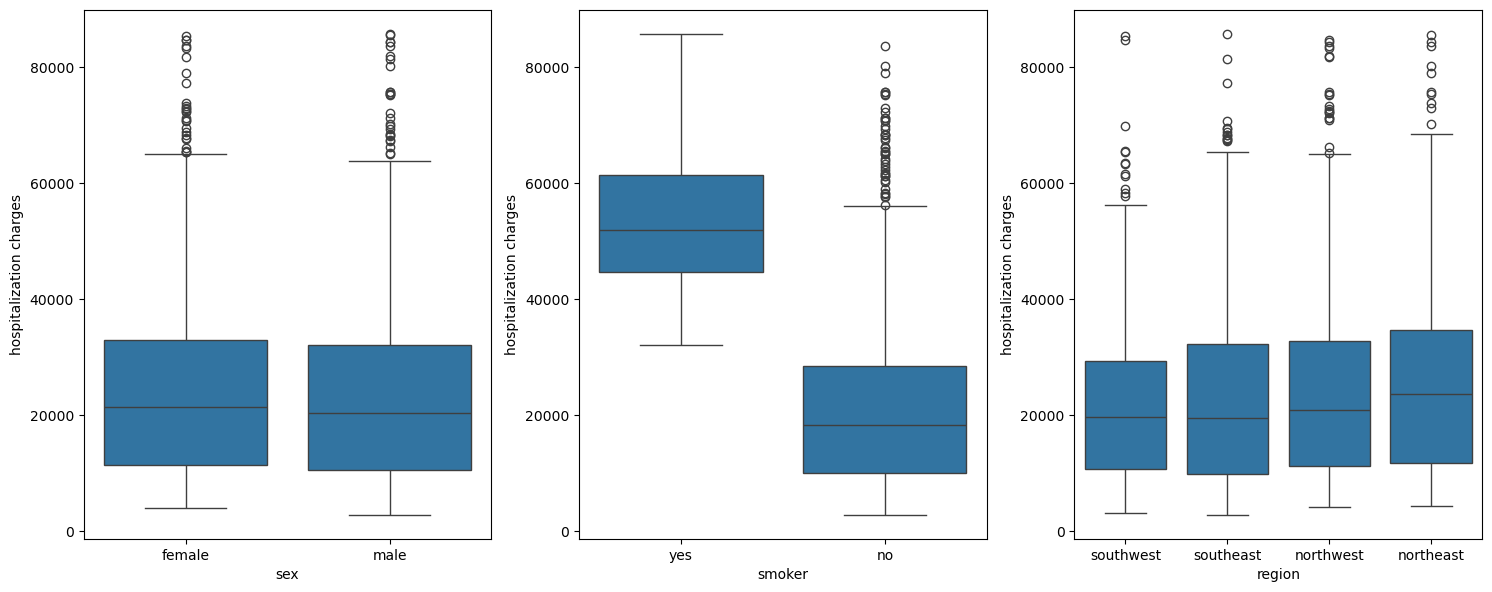

In [13]:
plt.figure(figsize=(15,6))
for i,j in enumerate(list(df.select_dtypes('object').columns)):
    plt.subplot(1,3,i+1)
    plt.subplots_adjust(hspace = 0.8)
    sbn.boxplot(x=j, y='hospitalization charges', data=df,patch_artist=True)
    plt.tight_layout(pad=1)


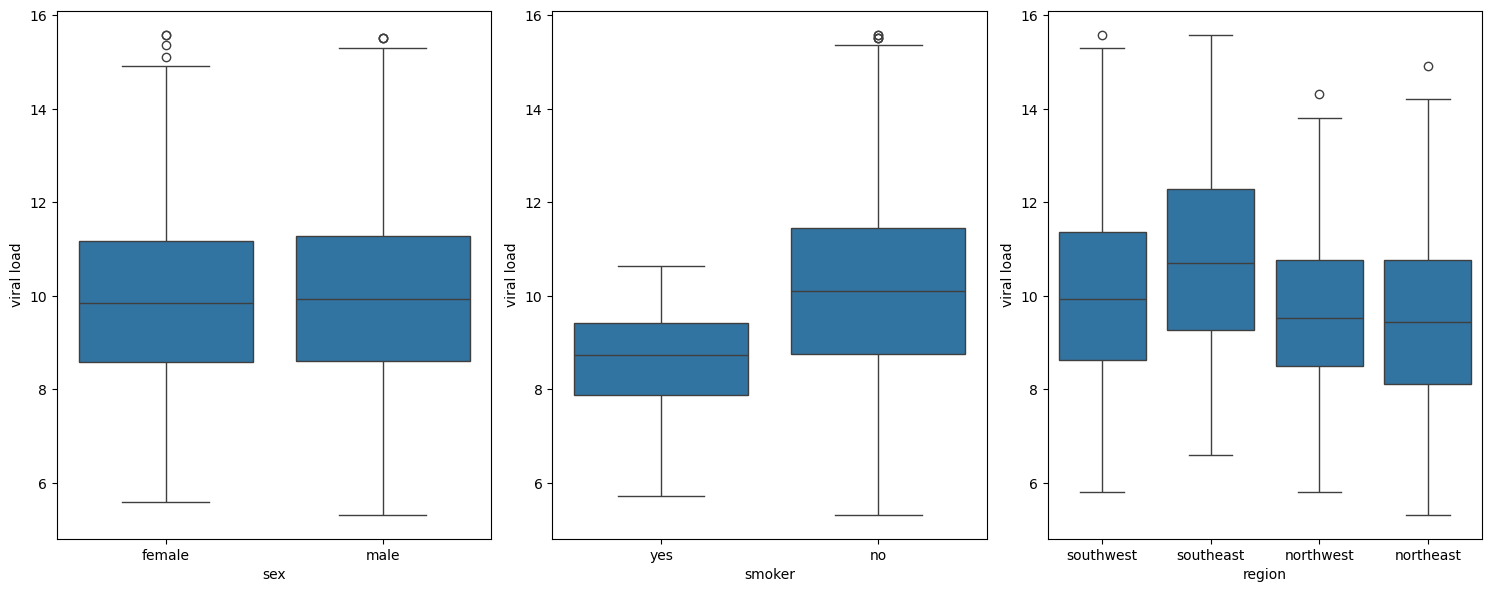

In [14]:
plt.figure(figsize=(15,6))
for i,j in enumerate(list(df.select_dtypes('object').columns)):
 plt.subplot(1,3,i+1)
 plt.subplots_adjust(hspace = 0.8)
 sbn.boxplot(x=j, y='viral load', data=df)
 plt.tight_layout(pad=1)

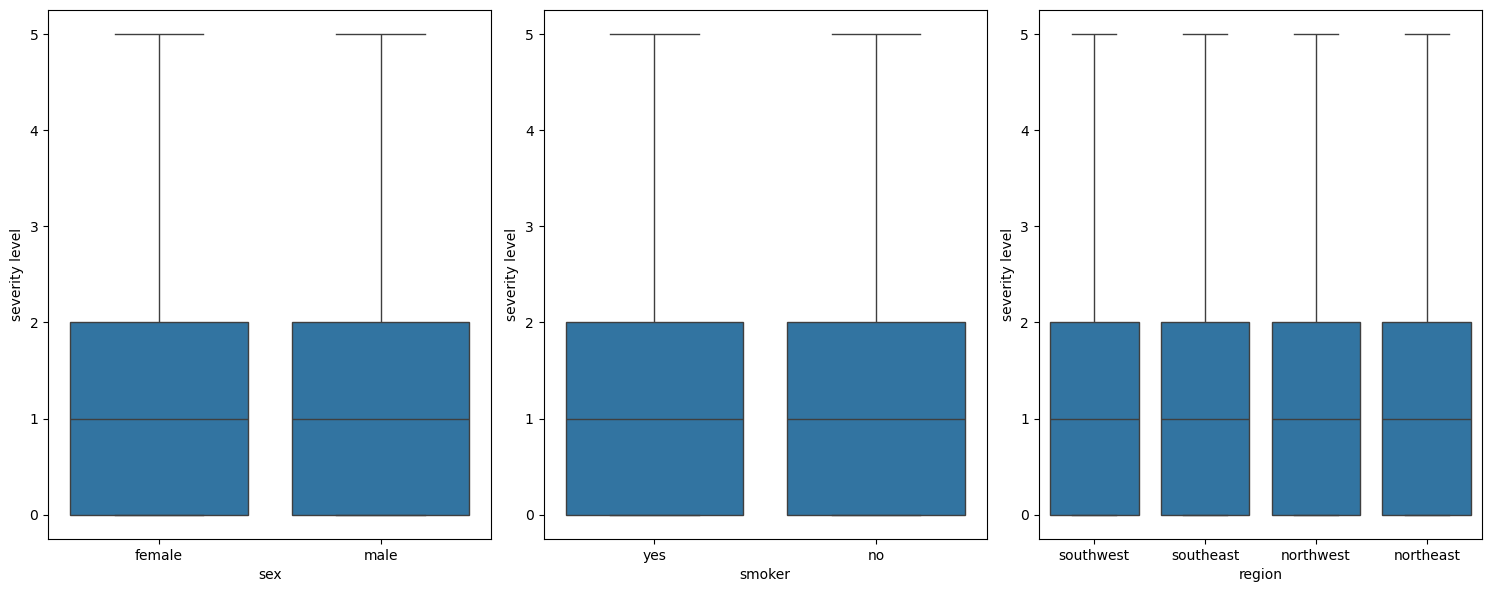

In [15]:
plt.figure(figsize=(15,6))
for i,j in enumerate(list(df.select_dtypes('object').columns)):
 plt.subplot(1,3,i+1)
 plt.subplots_adjust(hspace = 0.8)
 sbn.boxplot(x=j, y='severity level', data=df)
 plt.tight_layout(pad=1)

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1191 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   age                      1191 non-null   int64  
 1   sex                      1191 non-null   object 
 2   smoker                   1191 non-null   object 
 3   region                   1191 non-null   object 
 4   viral load               1191 non-null   float64
 5   severity level           1191 non-null   int64  
 6   hospitalization charges  1191 non-null   int64  
dtypes: float64(1), int64(3), object(3)
memory usage: 74.4+ KB


In [17]:
df['sex'].value_counts(dropna=False)

sex
female    610
male      581
Name: count, dtype: int64

In [18]:
df.corr(numeric_only=True)

,age,viral load,severity level,hospitalization charges
age,1.000000,0.123870,0.038179,0.448798
viral load,0.123870,1.000000,0.007495,-0.064444
severity level,0.038179,0.007495,1.000000,0.089083
hospitalization charges,0.448798,-0.064444,0.089083,1.000000


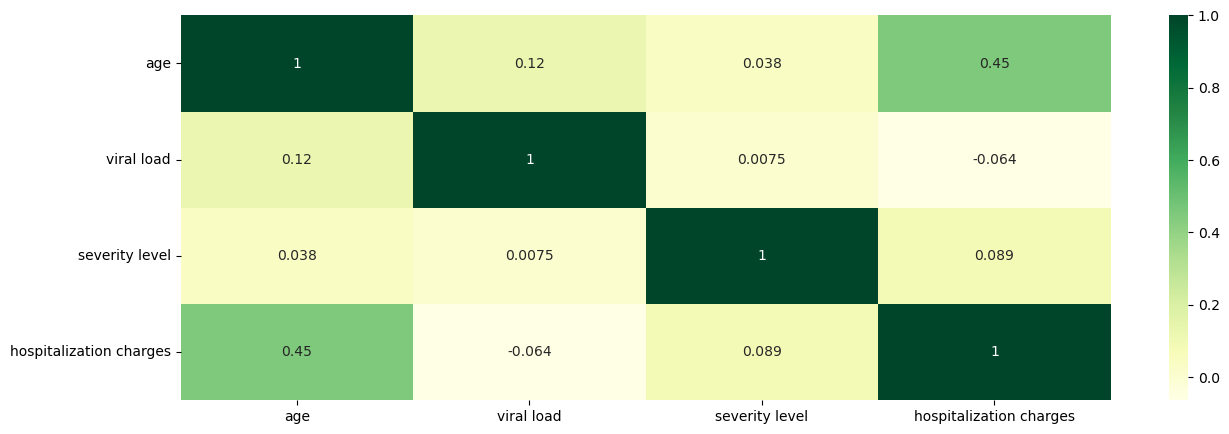

In [19]:
plt.figure(figsize=(15,5))
sbn.heatmap(df.corr(numeric_only=True),annot=True ,cmap="YlGn" )
plt.show()


In [20]:
## Deep Dive into Age

In [21]:
df['age bins']=pd.cut(x=df['age'], bins=[0,18,28,38,48,58,68,100],labels=['0-18','18-28','28-38','38-48','48-58','58-68','68-100'])

In [22]:
df.head()

,age,sex,smoker,region,viral load,severity level,hospitalization charges,age bins
0,19,female,yes,southwest,9.30,0,42212,18-28
1,18,male,no,southeast,11.26,1,4314,0-18
2,28,male,no,southeast,11.00,3,11124,18-28
3,33,male,no,northwest,7.57,0,54961,28-38
4,32,male,no,northwest,9.63,0,9667,28-38


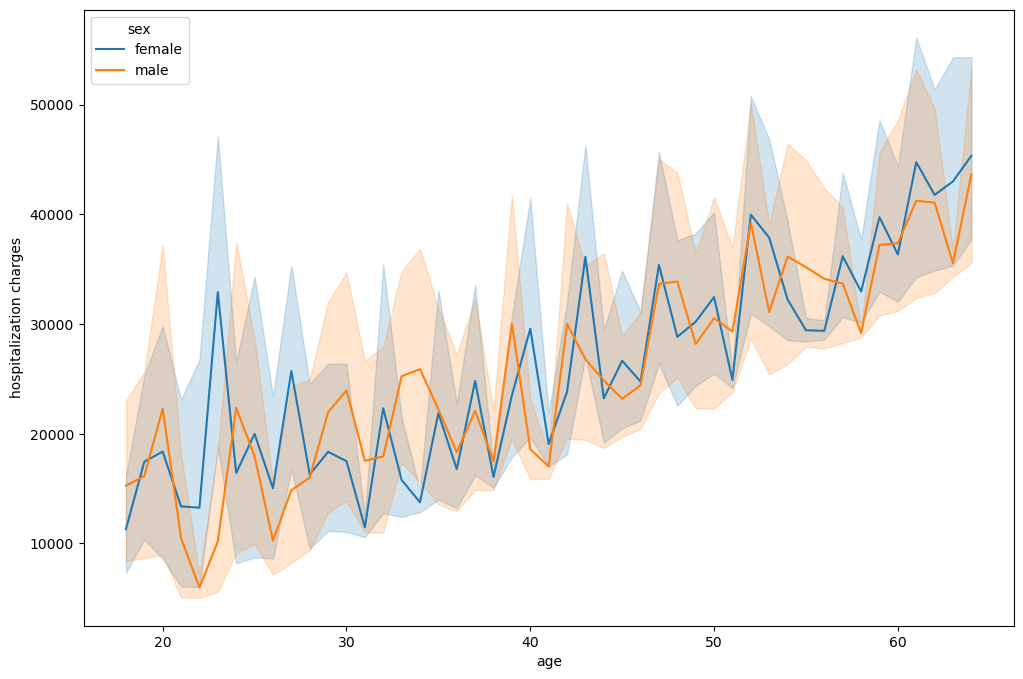

In [23]:
plt.figure(figsize=(12,8))
sbn.lineplot(x='age', y='hospitalization charges', data=df, hue='sex')
plt.show()

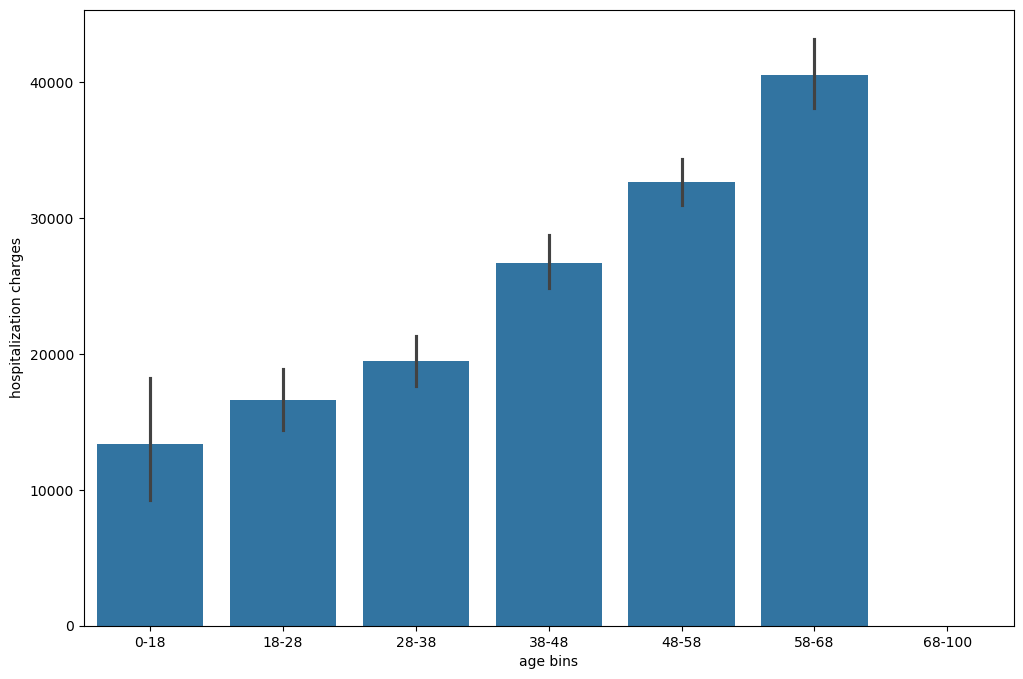

In [24]:
plt.figure(figsize=(12,8))
sbn.barplot(x='age bins', y='hospitalization charges', data=df)
plt.show()

In [25]:
df.groupby(['region','sex','smoker'])['hospitalization charges'].mean().unstack()

smoker                      no           yes
region    sex                               
northeast female  24105.053435  48756.263158
          male    21660.096000  56480.500000
northwest female  21967.518519  58942.350000
          male    20801.734848  56219.444444
southeast female  20590.739130  56240.470588
          male    19123.868217  53855.058824
southwest female  19585.122302  54129.909091
          male    19447.293651  50628.571429

## 1. Prove (or disprove) that the hospitalisation of people who do smoking is greater than those who don't? (t-test Right tailed)

In [26]:
df.groupby('smoker')['hospitalization charges'].describe()


,count,mean,std,min,25%,50%,75%,max
smoker,,,,,,,,
no,1055.0,20907.971564,14563.067125,2805.0,9962.5,18313.0,28387.5,83680.0
yes,136.0,54578.154412,13360.849267,32074.0,44663.5,51899.5,61421.5,85758.0


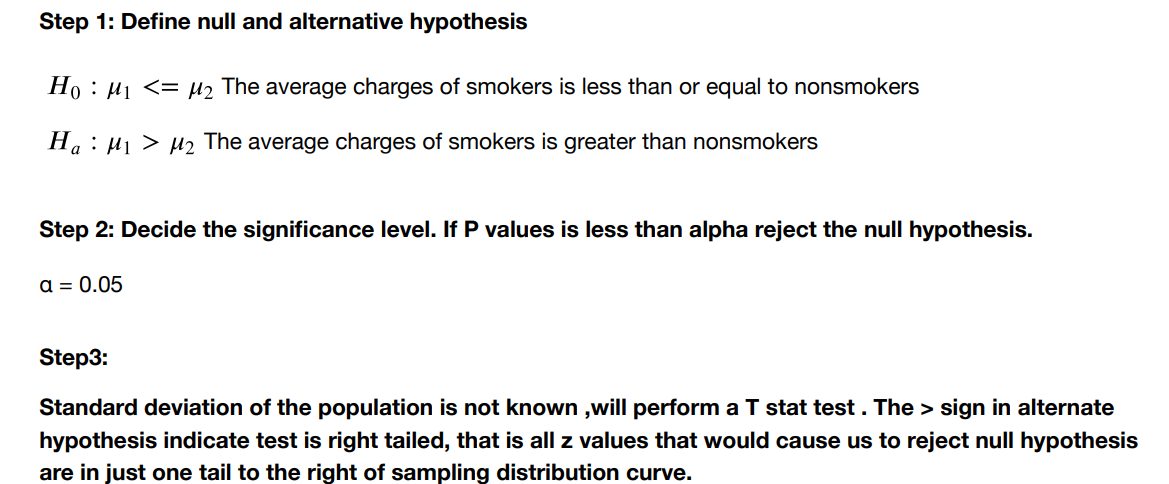

In [27]:
smoker=df[df['smoker']=='yes']['hospitalization charges'].sample(109)
non_smoker=df[df['smoker']=='no']['hospitalization charges'].sample(109)


In [28]:
alpha=0.05
t_statistic, p_value = stats.ttest_ind(smoker, non_smoker,equal_var=False)
#equal_var=False --> welch test--> doesn't assume variance to be equal
p_value_onetail=p_value/2
print(f"Test statistic = {t_statistic} , Pvalue ={p_value} , OnetailPvalue = {p_value_onetail}")

Test statistic = 20.03785256715997 , Pvalue =7.659372793496773e-51 , OnetailPvalue = 3.8296863967483863e-51


In [29]:
if p_value<alpha :
 print("Conclusion:Since P value {} is less than alpha {} ". format (p_value_onetail,alpha))
 print("Reject Null Hypothesis that Average charges for smokers are less than or equal to nonsmoker.")
else:
 print("Conclusion:Since P value {} is greater than alpha {} ". format (p_value_onetail))
 print("Failed to Reject Null Hypothesis that Average charges for smokers are less than or equal to nonsmoker")

Conclusion:Since P value 3.8296863967483863e-51 is less than alpha 0.05 
Reject Null Hypothesis that Average charges for smokers are less than or equal to nonsmoker.


In [30]:
#Alternative hypothesis is true

In [31]:
alpha=0.05
t_statistic, p_value = stats.ttest_ind(smoker, non_smoker, alternative='greater', equal_val=
print("Here Pvalue is automatically of ONE TAIL P VALUE ={} as you have specified th


SyntaxError: unterminated string literal (detected at line 3) (842315381.py, line 3)

In [ ]:
## 2. Prove (or disprove) with statistical evidence that the viral load of females is different from that of males

In [ ]:
df.groupby('sex')['viral load'].describe()


In [ ]:
male=df[df['sex']=='male']['viral load'].sample(581)
female=df[df['sex']=='female']['viral load'].sample(581)

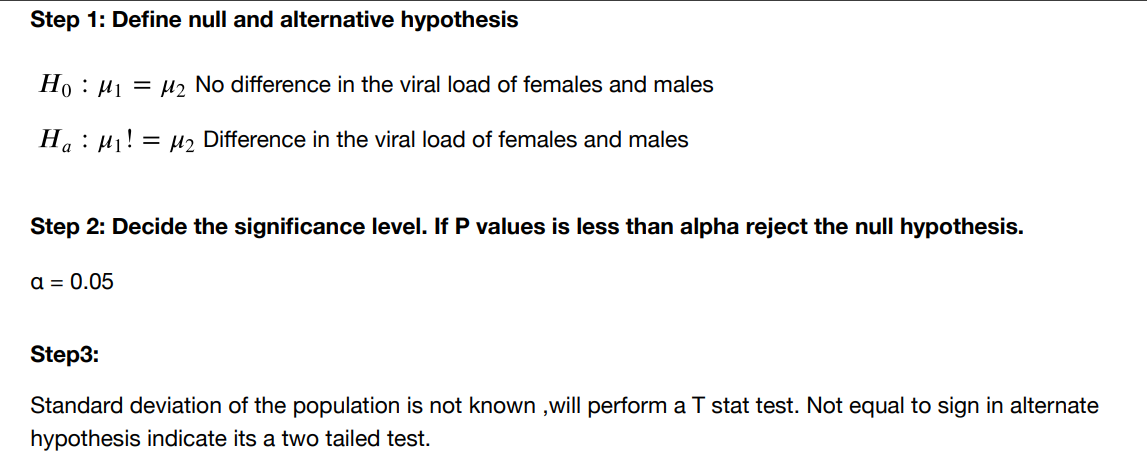

In [ ]:
alpha=0.05
t_statistic, p_value = stats.ttest_ind(male, female, alternative='two-sided')
print("Test statistic = {} , Pvalue ={} ".format(t_statistic,p_value ))

In [ ]:
sbn.distplot(male,color='green',hist=False)
sbn.distplot(female,color='red',hist=False)

In [ ]:
# 3. Is the proportion of smoking significantly different across different regions? (chi-square)

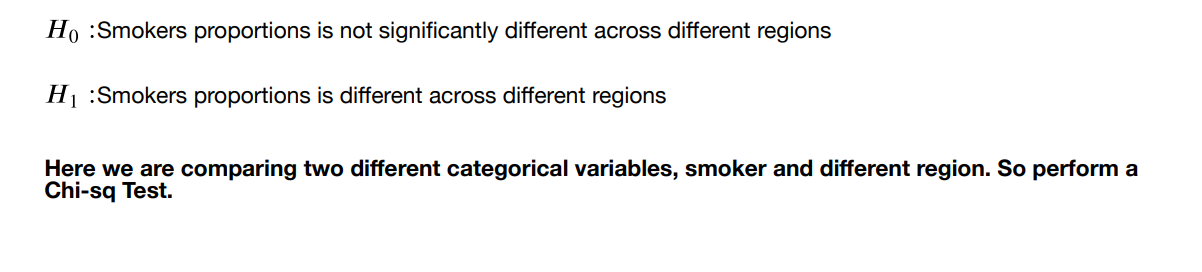

In [ ]:
contigency= pd.crosstab(df.region, df.smoker)
contigency


In [ ]:
df.groupby(['region','smoker'])['age'].count().unstack()


In [ ]:
contigency.plot(kind='bar')

In [ ]:
# Using the chi2_contingency test
chi2, pval, dof, exp_freq = chi2_contingency(contigency, correction = False)
print('chi-square statistic: {} , Pvalue: {} , Degree of freedom: {} ,expected frequ

In [ ]:
if (pval < 0.05):
 print('Reject Null Hypothesis')
else:
 print('Failed to reject Null Hypothesis')

In [32]:
# 4. Is the mean viral load of women with 0 Severity level ,1 Severity level, and 2 Severity level the same? Explain your answer with statistical evidence.

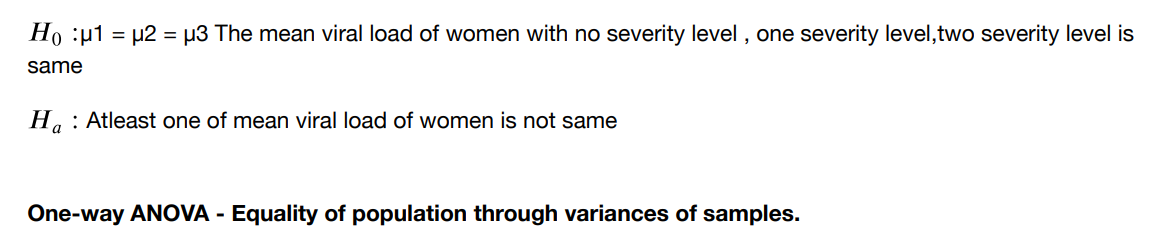

In [33]:
df[df['sex']=='female'].groupby('severity level')['viral load'].describe().head(3)


,count,mean,std,min,25%,50%,75%,max
severity level,,,,,,,,
0,268.0,9.963209,1.936862,5.76,8.6075,9.695,11.1300,14.92
1,147.0,9.908844,1.918987,5.60,8.6000,9.670,11.1300,15.36
2,106.0,9.945000,2.092305,5.73,8.3450,10.060,11.2025,15.57


In [34]:
df_female_severe=df[df['sex']=='female'].loc[df[df['sex']=='female']['severity level']<=2]


In [35]:
df_female_severe.head()


,age,sex,smoker,region,viral load,severity level,hospitalization charges,age bins
0,19,female,yes,southwest,9.30,0,42212,18-28
5,31,female,no,southeast,8.58,0,9392,28-38
6,46,female,no,southeast,11.15,1,20601,38-48
9,60,female,no,northwest,8.61,0,72308,58-68
11,62,female,yes,southeast,8.76,0,69522,58-68


In [36]:
df_female_severe.shape

(521, 8)

In [37]:
df_female_severe['severity level'].value_counts()


severity level
0    268
1    147
2    106
Name: count, dtype: int64

<Axes: xlabel='severity level', ylabel='viral load'>

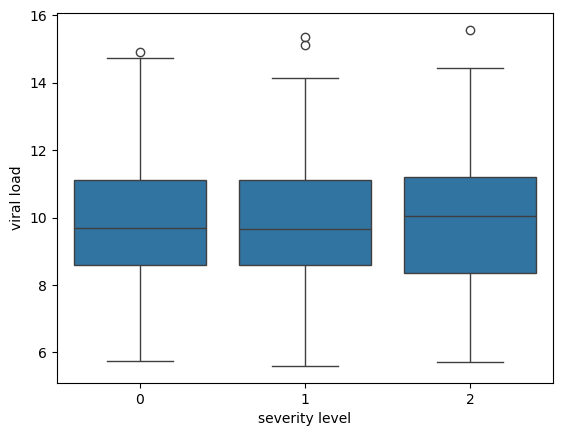

In [38]:
sbn.boxplot(x='severity level', y='viral load', data=df_female_severe)

In [39]:
# Normality Assumption Check

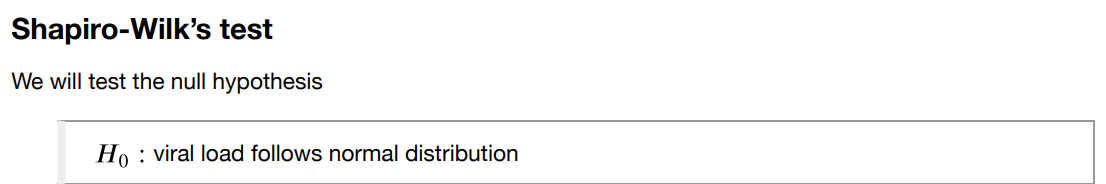
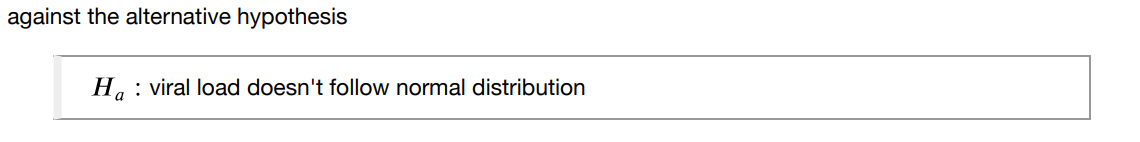

In [40]:
# Assumption 1: Normality
# import the required function
from scipy.stats import shapiro
# find the p-value
w, p_value = shapiro(df_female_severe['viral load']) 
print('The p-value is', p_value)

The p-value is 0.00681329796386258


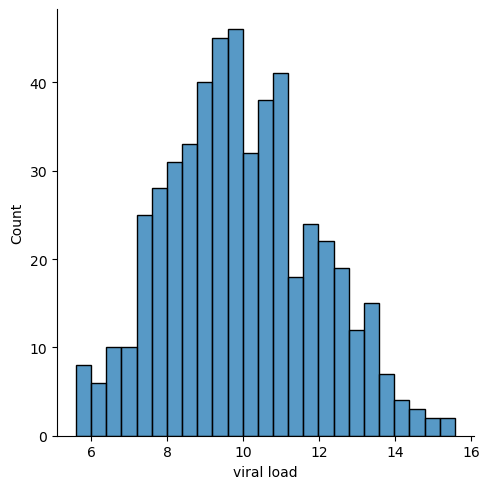

In [41]:
sbn.displot(df_female_severe['viral load'],bins=25) #this looks normal. since the da


In [42]:
# Assumption 1: Normality
# import the required function
from scipy.stats import shapiro
# find the p-value
w, p_value = shapiro(np.log(df_female_severe['viral load']) )
print('The p-value is', p_value)

The p-value is 0.009905007805750357


In [43]:
# Homogeneity of variance Assumption Check


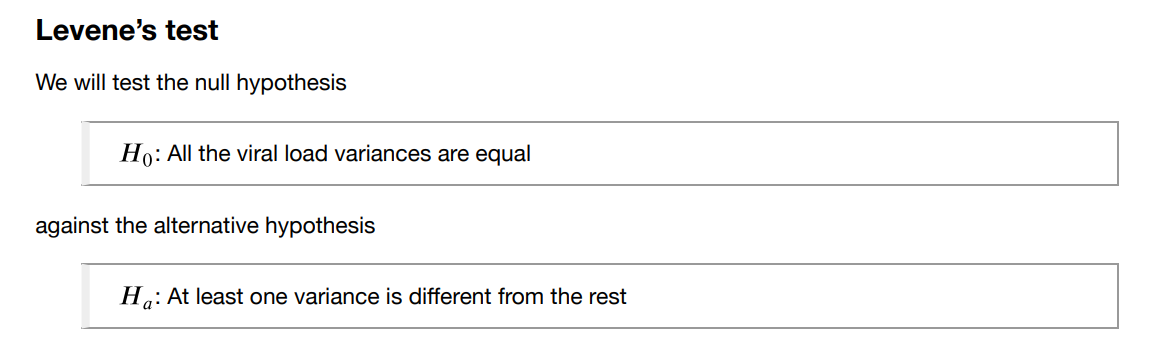

In [44]:
df_female_severe[df_female_severe['severity level']==0]['viral load'].sample(106)

743     8.87
999     8.96
448     9.87
605    11.37
290    11.13
       ...  
354    12.76
50     11.88
135     9.35
920     8.33
134     9.60
Name: viral load, Length: 106, dtype: float64

In [45]:
#Assumption 2: Homogeneity of Variance
#import the required function
from scipy.stats import levene
statistic, p_value = levene(df_female_severe[df_female_severe['severity level']==0]['viral load'].sample(101),
                            df_female_severe[df_female_severe['severity level']==1]['viral load'].sample(101),
                            df_female_severe[df_female_severe['severity level']==2]['viral load'].sample(101))
# find the p-value
print('The p-value is', p_value.item())

The p-value is 0.6934941783206894


In [46]:
p_value.item()>0.05

True

In [47]:
## Anova

In [48]:
# import the required function
from scipy.stats import f_oneway
# find the p-value
test_stat, p_value = f_oneway(df_female_severe[df_female_severe['severity level']==0]['viral load'].sample(101),
                            df_female_severe[df_female_severe['severity level']==1]['viral load'].sample(101),
                            df_female_severe[df_female_severe['severity level']==2]['viral load'].sample(101))
# print the p-value
print('The p-value is', p_value)

The p-value is 0.8781867748946485


In [49]:
# print the conclusion based on p-value
if p_value < 0.05:
 print(f'As the p-value {p_value} is less than the level of significance, we reject the null hypothesis')
else:
 print(f'As the p-value {p_value} is greater than the level of significance, we fail to reject the null hypothesis')

As the p-value 0.8781867748946485 is greater than the level of significance, we fail to reject the null hypothesis
